# Miniproject - Neuroscience: cellular and circuit mechanisms (BIO-482)

This notebook contains the part 4 of the miniproject - the personal project. In this part we investigate the **classification among all cell types for active touch.**


#### Importing libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

#### Importing helper functions
 Feel free to check out what these functions do in the corresponding files, `helpers.py` or `utils.py`. 
 - `helpers.py` contains functions to analyze membrane potential recording data
 - `utils.py` contains functions useful for other things e.g. plotting

In [2]:
base_path = os.getcwd()
base_path = base_path.replace('notebooks', 'scripts') # note: if you have notebooks twice in your base_path, this won't work
sys.path.insert(1, base_path)

from helpers import *
from utils import remove_top_right_frame, jitter_scatterplot

# Load and preprocess the data
Load previously saved dataframe as `.csv` file:

In [3]:
# Load the first dataset
df_1 = pd.read_csv('../data/df_1_act.csv')
df_1.head(3)

,Unnamed: 0,cell_id,cell_type,firing_rate,ap_threshold,ap_duration,mean_vm,std_vm,fft_low,fft_high
0,0,JP902_1,EXC,1.062500,-0.038696,0.670588,-0.061195,0.006330,0.000880,0.000066
1,1,JP903_1,EXC,1.750000,-0.039856,1.126786,-0.054889,0.004605,0.000627,0.000092
2,2,JP905_1,EXC,1.391667,-0.036766,0.802096,-0.058734,0.005968,0.000710,0.000054


In [4]:
# Load the second dataset
df_2 = pd.read_csv('../data/df_2_act.csv')
df_2.head(3)

,Unnamed: 0,cell_id,cell_type,numb_events,wp_avg,wp_amplitude_pre,wp_amplitude_post,vm_avg,vm_amplitude_pre,vm_amplitude_post,ap_avg,ap_psth,ap_fr_pre,ap_fr_post
0,0,JP902_1,EXC,13,[ 1.63032302 1.36424201 1.23725137 0.951374...,1.205101,-0.004314,[-0.05661346 -0.0565887 -0.0566137 ... -0.05...,-56.567212,-56.279934,[0. 0. 0. ... 0. 0. 0.],[0. 0. 0. 1.53846154 0...,0.384712,0.384712
1,1,JP903_1,EXC,13,[ 5.59008105 5.36690932 5.72071861 5.864409...,5.463008,7.853982,[-0.06675505 -0.06674783 -0.0667613 ... -0.06...,-66.712320,-66.468130,[0. 0. 0. ... 0. 0. 0.],[0. 0. 0. 0. 1...,0.000000,0.384712
2,2,JP905_1,EXC,14,[5.20685063 5.28445094 5.3122831 5.32105406 5...,5.774538,5.002845,[-0.05909152 -0.05907611 -0.05908348 ... -0.05...,-58.051123,-55.833821,[0. 0. 0. ... 0. 0. 0.],[0. 0. 0. 0. 0...,0.000000,1.071696


In [5]:
# Merge them and suppress unwanted columns
df = df_1.merge(df_2, on=['cell_id', 'cell_type'])
df = df.drop(['Unnamed: 0_x', 'Unnamed: 0_y'], axis=1)
df.head(3)

,cell_id,cell_type,firing_rate,ap_threshold,ap_duration,mean_vm,std_vm,fft_low,fft_high,numb_events,wp_avg,wp_amplitude_pre,wp_amplitude_post,vm_avg,vm_amplitude_pre,vm_amplitude_post,ap_avg,ap_psth,ap_fr_pre,ap_fr_post
0,JP902_1,EXC,1.062500,-0.038696,0.670588,-0.061195,0.006330,0.000880,0.000066,13,[ 1.63032302 1.36424201 1.23725137 0.951374...,1.205101,-0.004314,[-0.05661346 -0.0565887 -0.0566137 ... -0.05...,-56.567212,-56.279934,[0. 0. 0. ... 0. 0. 0.],[0. 0. 0. 1.53846154 0...,0.384712,0.384712
1,JP903_1,EXC,1.750000,-0.039856,1.126786,-0.054889,0.004605,0.000627,0.000092,13,[ 5.59008105 5.36690932 5.72071861 5.864409...,5.463008,7.853982,[-0.06675505 -0.06674783 -0.0667613 ... -0.06...,-66.712320,-66.468130,[0. 0. 0. ... 0. 0. 0.],[0. 0. 0. 0. 1...,0.000000,0.384712
2,JP905_1,EXC,1.391667,-0.036766,0.802096,-0.058734,0.005968,0.000710,0.000054,14,[5.20685063 5.28445094 5.3122831 5.32105406 5...,5.774538,5.002845,[-0.05909152 -0.05907611 -0.05908348 ... -0.05...,-58.051123,-55.833821,[0. 0. 0. ... 0. 0. 0.],[0. 0. 0. 0. 0...,0.000000,1.071696


In [6]:
print(df_1.shape)
print(df_2.shape)
print(df.shape)

(134, 10)
(134, 14)
(134, 20)


In [7]:
# Remove columns with strings 
df = df.drop(['cell_id', 'wp_avg', 'vm_avg', 'ap_avg', 'ap_psth'], axis=1)

index_col = list(df['cell_type'].unique())

# Transform the labels into numbers
df['cell_type'] = df['cell_type'].apply(index_col.index)

# Replace NaN values with 0
df.fillna(0, inplace=True)
df.head(5)

,cell_type,firing_rate,ap_threshold,ap_duration,mean_vm,std_vm,fft_low,fft_high,numb_events,wp_amplitude_pre,wp_amplitude_post,vm_amplitude_pre,vm_amplitude_post,ap_fr_pre,ap_fr_post
0,0,1.062500,-0.038696,0.670588,-0.061195,0.006330,0.000880,0.000066,13,1.205101,-0.004314,-56.567212,-56.279934,0.384712,0.384712
1,0,1.750000,-0.039856,1.126786,-0.054889,0.004605,0.000627,0.000092,13,5.463008,7.853982,-66.712320,-66.468130,0.000000,0.384712
2,0,1.391667,-0.036766,0.802096,-0.058734,0.005968,0.000710,0.000054,14,5.774538,5.002845,-58.051123,-55.833821,0.000000,1.071696
3,0,1.066667,-0.031500,0.993750,-0.053566,0.006013,0.000757,0.000073,19,2.027979,3.041820,-57.561066,-55.488854,0.000000,1.052895
4,0,0.600000,-0.040162,0.841667,-0.059964,0.004342,0.000476,0.000054,12,-3.327526,-3.169704,-54.709178,-54.485818,0.000000,0.000000


In [8]:
# Create the X, y datasets
X = df.loc[:, df.columns != 'cell_type']
y = df['cell_type']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
df.shape

(134, 15)

### Multiple Logistic Regression

Logistic Regression Accuracy: 0.7777777777777778


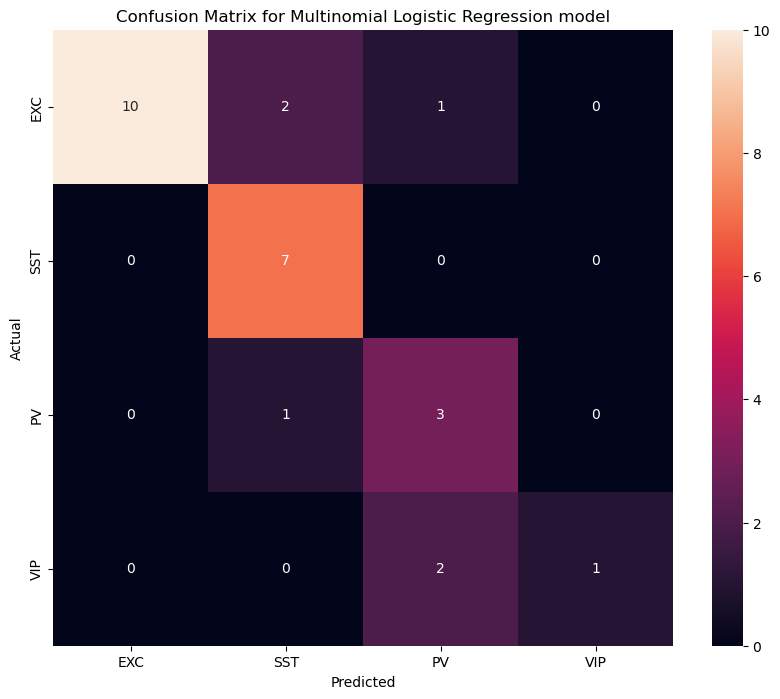

In [10]:
# Create Logistic Regression model
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100000)

# Fit the model to the training data
lr.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = lr.predict(X_test)

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f'Logistic Regression Accuracy: {accuracy_lr}')

# Create confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_df_lr = pd.DataFrame(cm_lr, index = index_col, columns = index_col)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df_lr, annot=True)
plt.title('Confusion Matrix for Multinomial Logistic Regression model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### Random Forest

Random Forest accuracy: 0.6296296296296297


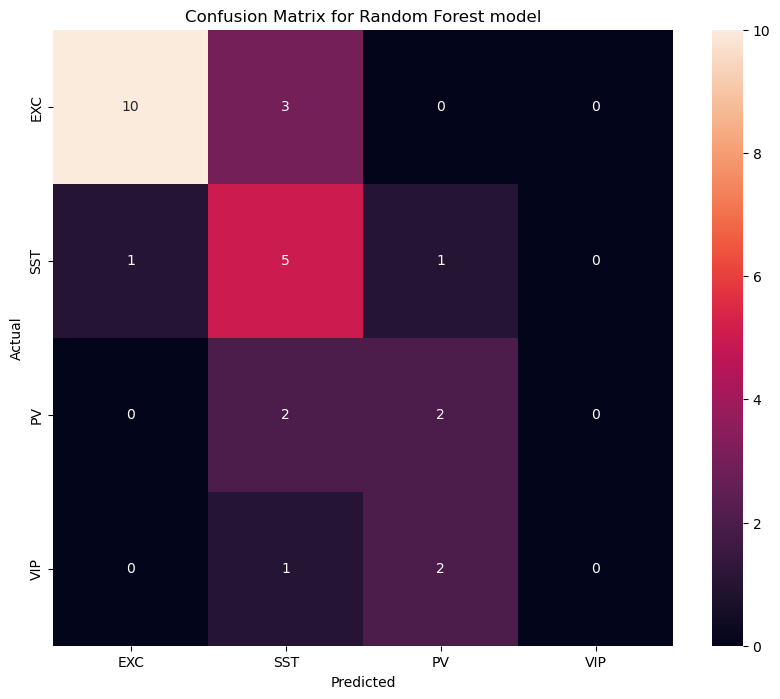

In [11]:
# Create Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf.predict(X_test)
#y_probs_rf = rf.predict_proba(X_test)
#roc_auc_rf = roc_auc_score(y_test, y_probs_rf, multi_class='ovr', average='micro')
#fpr_rf, tpr_rf, _ = roc_curve(y_test.ravel(), y_probs_rf.ravel())

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest accuracy: {accuracy_rf}')

# Create confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_df_rf = pd.DataFrame(cm_rf, index = index_col, columns = index_col)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df_rf, annot=True)
plt.title('Confusion Matrix for Random Forest model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### K-Nearest Neighbors

KNN accuracy: 0.7407407407407407


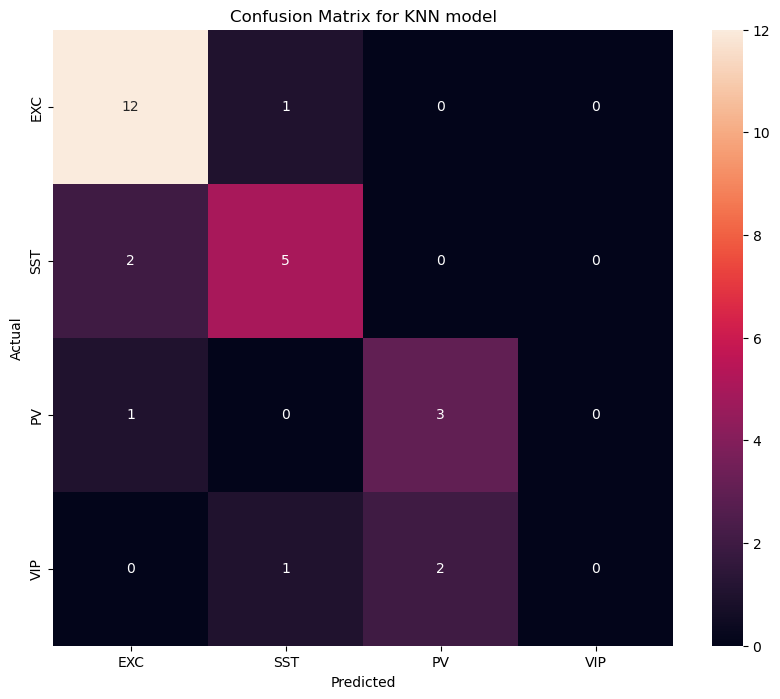

In [12]:
# Create knn model
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model to the training data
knn.fit(X_train, y_train)

# Predict on the test set
y_pred_knn = knn.predict(X_test)

# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'KNN accuracy: {accuracy_knn}')

# Create confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_df_knn = pd.DataFrame(cm_knn, index = index_col, columns = index_col)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df_knn, annot=True)
plt.title('Confusion Matrix for KNN model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Support Vector Machine

SVM accuracy: 0.7777777777777778


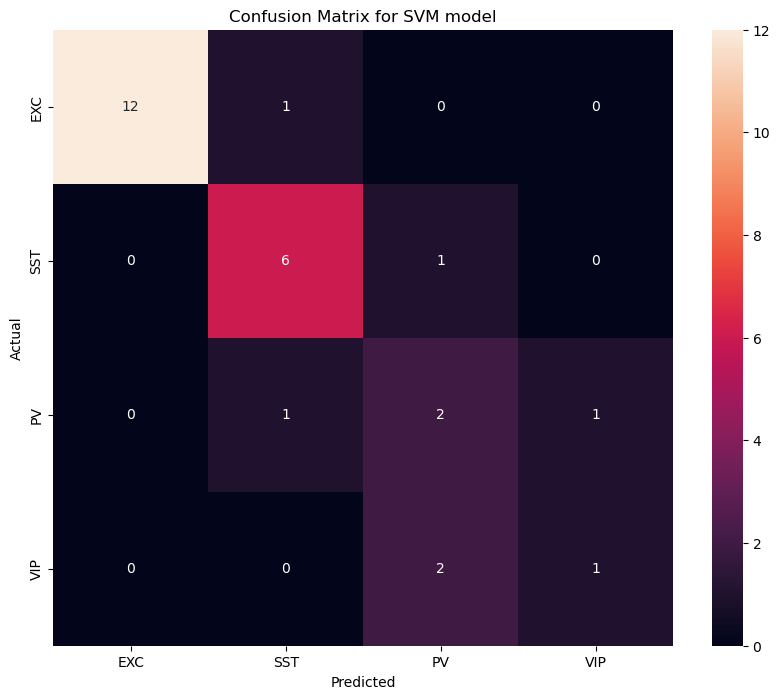

In [13]:
# Create SVM model
svm = SVC(kernel='linear', C=1.0, random_state=42)

# Fit the model to the training data
svm.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm.predict(X_test)

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'SVM accuracy: {accuracy_svm}')

# Create confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_df_svm = pd.DataFrame(cm_svm, index = index_col, columns = index_col)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df_svm, annot=True)
plt.title('Confusion Matrix for SVM model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()